In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.feature_selection import RFECV
from sklearn import metrics
import math
from pprint import pprint
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(12,8)})

In [98]:
def score_model(model):
  y_pred = model.predict(x_test)
  print("R2 score =", round(metrics.r2_score(y_test, y_pred), 2))
  print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_pred), 2)) 
  print("Root mean squared error =", round(math.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2))

def save_model(model, filename):
  with open("../models/tree_models/" + filename + ".pickle", "wb") as f:
    pickle.dump(model, f)
  print('Model saved as ' + filename + '.pickle')

### Loading and Splitting the Data

In [99]:
data = pd.read_csv('../data/teams_normalized.csv')

# separating the dataset into section ready for model fitting
train, test = train_test_split(data, test_size=0.15, train_size=0.85)
x_cols = ['Age', 'ORtg', 'DRtg', 'NRtg', 'Pace', '3PAr_Norm', 'FTr', 'TS%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'OeFG%', 'OTOV%', 'DRB%', 'OFT/FGA']
y_col = 'W'

x_train = train[x_cols]
y_train = train[y_col]
x_test= test[x_cols]
y_test = test[y_col]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(957, 16) (957,) (169, 16) (169,)


### Training the Model
We can select the loss function as the criterion for the decision tree.

In [100]:
decision_tree = tree.DecisionTreeRegressor(
  max_depth=7
)

decision_tree.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=7)

### Evaluating the Model

In [101]:
score_model(decision_tree)

R2 score = 0.87
Mean absolute error = 3.43
Root mean squared error = 4.95


In [102]:
print('Feature Importance:')
pprint(
  dict(zip(x_cols, decision_tree.feature_importances_))
  )

Feature Importance:
{'3PAr_Norm': 0.0016147342084601014,
 'Age': 0.003057989773680969,
 'DRB%': 0.006907926581895618,
 'DRtg': 0.01052575358118071,
 'FT/FGA': 0.0021120611258507015,
 'FTr': 0.0006948895178692541,
 'NRtg': 0.9416880452678547,
 'OFT/FGA': 0.0016500782943670877,
 'ORB%': 0.0015593285862743522,
 'ORtg': 0.007882448806007442,
 'OTOV%': 0.00012865383073691695,
 'OeFG%': 0.0038985877573700324,
 'Pace': 0.005182543889132455,
 'TOV%': 0.0018508722921521412,
 'TS%': 0.007336461746671462,
 'eFG%': 0.003909624740496002}


This model relies heavily on the Net Rating metric, and pretty minimizes all the other columns.

In [103]:
tree.export_graphviz(
  decision_tree, 
  out_file='../models/tree_models/decision_tree.dot',
  feature_names=x_cols)

save_model(decision_tree, 'decision_tree')

Model saved as decision_tree.pickle


With this .dot file, we can visualize the actual decision tree the computer uses to calculate win totals. 

### Random Forest Regression
With the decison tree model, we can only have one tree, which limits the amount of computation, but with the RandomForest model we can use many different trees to make a forest and then make a compiled result. 

In [104]:
random_forest = ensemble.RandomForestRegressor(
  n_estimators=500
)

random_forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=500)

In [105]:
score_model(random_forest)

R2 score = 0.89
Mean absolute error = 3.27
Root mean squared error = 4.4


Feature Importance:
{'3PAr_Norm': 0.005491635431041866,
 'Age': 0.007214104330086701,
 'DRB%': 0.0063988714302483695,
 'DRtg': 0.007934346063283271,
 'FT/FGA': 0.005579110395274766,
 'FTr': 0.005401711297424005,
 'NRtg': 0.9023936339602676,
 'OFT/FGA': 0.00789719108531173,
 'ORB%': 0.003965981045275275,
 'ORtg': 0.008305247889231537,
 'OTOV%': 0.004385545468294976,
 'OeFG%': 0.008251589632889491,
 'Pace': 0.009693677066140518,
 'TOV%': 0.005276343866120439,
 'TS%': 0.006207802918046228,
 'eFG%': 0.005603208121062971}
Model saved as random_forest.pickle


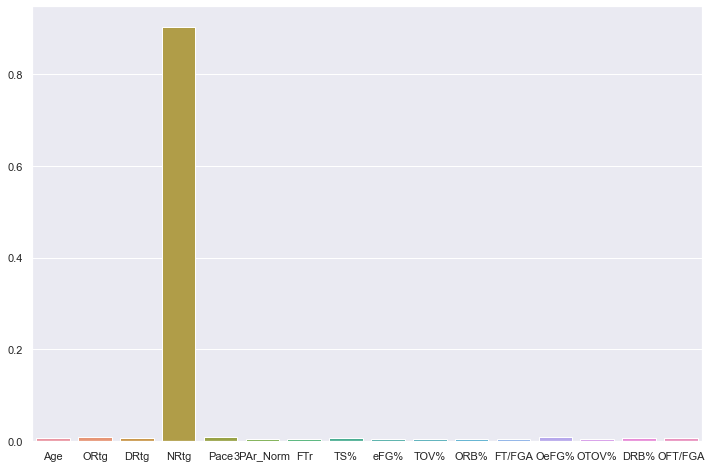

In [106]:
rf_feature_importance = dict(zip(x_cols, random_forest.feature_importances_))

print('Feature Importance:')
pprint(rf_feature_importance)
sns.barplot(
  x=list(rf_feature_importance.keys()),
  y=list(rf_feature_importance.values()))

save_model(random_forest, 'random_forest')

Cleary, only a few statistics are needed in determining the win counts. One of the great uses of Random Forest Regression, is that we can use feature elimination to narrow down the best criteria to use.

In [108]:
rfe_estimator = ensemble.RandomForestRegressor()
rfe = RFECV(
  rfe_estimator, cv=5, scoring='neg_mean_squared_error'
)
rfe.fit(x_train, y_train)

RFECV(cv=5, estimator=RandomForestRegressor(), scoring='neg_mean_squared_error')

In [114]:
score_model(rfe)

R2 score = 0.89
Mean absolute error = 3.27
Root mean squared error = 4.44
